<a href="https://colab.research.google.com/github/nilakshi104/NLP/blob/master/Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- movie_lines.txt
	- contains the actual text of each utterance
	- fields:
		- lineID
		- characterID (who uttered this phrase)
		- movieID
		- character name
		- text of the utterance

- movie_conversations.txt
	- the structure of the conversations
	- fields
		- characterID of the first character involved in the conversation
		- characterID of the second character involved in the conversation
		- movieID of the movie in which the conversation occurred
		- list of the utterances that make the conversation, in chronological 
			order: ['lineID1','lineID2',É,'lineIDN']
			has to be matched with movie_lines.txt to reconstruct the actual content

So while preparing dataset we have to map 2 files


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from io import open
import re
import os
import unicodedata
import csv
import codecs
import itertools
import math
import random
# from torch.jit import script, trace

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
conversation_path='/content/drive/My Drive/Projects/NLP/data/chatbot/movie_conversations.txt'
line_path='/content/drive/My Drive/Projects/NLP/data/chatbot/movie_lines.txt'

In [4]:
def printLines(filename,n=10):
  with open(filename,'rb') as datafile:             #'rb': read file in binary(with character not possible) format.Everything which can't encoded in text can be read in binary mode
    lines=datafile.readlines()
  for line in lines[:n]:
    print(line)

printLines(line_path)

b'L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!\n'
b'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!\n'
b'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.\n'
b'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?\n'
b"L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.\n"
b'L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow\n'
b"L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.\n"
b'L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No\n'
b'L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?\n'
b'L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?\n'


In [5]:
printLines(conversation_path)

b"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']\n"
b"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']\n"
b"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L200', 'L201', 'L202', 'L203']\n"
b"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L204', 'L205', 'L206']\n"
b"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L207', 'L208']\n"
b"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L271', 'L272', 'L273', 'L274', 'L275']\n"
b"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L276', 'L277']\n"
b"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L280', 'L281']\n"
b"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L363', 'L364']\n"
b"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L365', 'L366']\n"


In [6]:
def loadLines(filename,fields):
  lines={}
  with open(filename,'r',encoding='iso-8859-1') as f:     #read file with characters
    for line in f:
      values=line.split(' +++$+++ ')
      lineObj={}
      for i,field in enumerate(fields):
        lineObj[field]=values[i]
      lines[lineObj['lineID']]=lineObj
  return lines

MOVIE_LINES_FIELDS = ["lineID", "characterID", "movieID", "character", "text"]
lines=loadLines(line_path,MOVIE_LINES_FIELDS)
# lines

In [7]:
def loadConversations(filename,lines,fields):
  conversations=[]
  with open(filename,'r',encoding='iso-8859-1') as f:
    for line in f:
      values=line.split(' +++$+++ ')
      convObj={}
      for i,field in enumerate(fields):
        convObj[field]=values[i]
      utterance_id_pattern =re.compile('L[0-9]+')
      lineIds=utterance_id_pattern.findall(convObj['utteranceIDs'])
      convObj['lines']=[]
      for lineId in lineIds:
        convObj['lines'].append(lines[lineId])
      conversations.append(convObj)
  return conversations

MOVIE_CONVERSATIONS_FIELDS=["character1ID","character2ID","movieID","utteranceIDs"]
conversations=loadConversations(conversation_path,lines,MOVIE_CONVERSATIONS_FIELDS)
# conversations

In [8]:
def extractSentencePairs(conversations):
  qa_pairs=[]
  for conversation in conversations:
    for i in range(len(conversation['lines'])-1):
      inputLine=conversation["lines"][i]["text"].strip()
      targetLine=conversation["lines"][i+1]["text"].strip()
      if inputLine and targetLine:
        qa_pairs.append([inputLine,targetLine])
  return qa_pairs

qa_pairs=extractSentencePairs(conversations)
qa_pairs[0:10]

[['Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.',
  "Well, I thought we'd start with pronunciation, if that's okay with you."],
 ["Well, I thought we'd start with pronunciation, if that's okay with you.",
  'Not the hacking and gagging and spitting part.  Please.'],
 ['Not the hacking and gagging and spitting part.  Please.',
  "Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?"],
 ["You're asking me out.  That's so cute. What's your name again?",
  'Forget it.'],
 ["No, no, it's my fault -- we didn't have a proper introduction ---",
  'Cameron.'],
 ['Cameron.',
  "The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does."],
 ["The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.",
  'Seems like she could get a date easy enough...'],
 [

In [9]:
datafile='/content/drive/My Drive/Projects/NLP/data/chatbot/formatted_movie_lines1.txt'
delimiter='\t'
# delimiter=str(codecs.decode(delimiter,"unicode_escape"))

lines={}
conversations=[]
MOVIE_LINES_FIELDS=["lineID","characterID","movieID","character","text"]
MOVIE_CONVERSATIONS_FIELDS=["character1ID","character2ID","movieID","utteranceIDs"]

print('\nProcessing corpus...')
lines=loadLines(line_path,MOVIE_LINES_FIELDS)
print('\nloading conversatins...')
conversations=loadConversations(conversation_path,lines,MOVIE_CONVERSATIONS_FIELDS)

print("\nWriting newly formatted file...")
with open(datafile,'w',encoding='utf-8') as outputfile:
  writer=csv.writer(outputfile,delimiter=delimiter,lineterminator='\n')
  for pair in extractSentencePairs(conversations):
    writer.writerow(pair)

print("\nSample lines from file:")
printLines(datafile)


Processing corpus...

loading conversatins...

Writing newly formatted file...

Sample lines from file:
b"Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\tWell, I thought we'd start with pronunciation, if that's okay with you.\n"
b"Well, I thought we'd start with pronunciation, if that's okay with you.\tNot the hacking and gagging and spitting part.  Please.\n"
b"Not the hacking and gagging and spitting part.  Please.\tOkay... then how 'bout we try out some French cuisine.  Saturday?  Night?\n"
b"You're asking me out.  That's so cute. What's your name again?\tForget it.\n"
b"No, no, it's my fault -- we didn't have a proper introduction ---\tCameron.\n"
b"Cameron.\tThe thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.\n"
b"The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date

- PreProcessing

  - reading data

  - converting unicode to ascii

  - normalizing string..removing unwanted characters

  - trimming data   (removing words whose occurence is below particular threshold))

  - Removing sentences whose length is greater than max_length


In [10]:
PAD_token=0
SOS_token=1
EOS_token=2

class Voc:
  def __init__(self,name):
    self.name=name
    self.word2index={}
    self.word2count={}
    self.index2word={PAD_token:'PAD',SOS_token:'SOS',EOS_token:'EOS'}
    self.num_words=3

  def addSentence(self,sentence):
    for word in sentence.split(' '):
      self.addWord(word)               #we can call another function defined in class in class itself
  
  def addWord(self,word):
    if word not in self.word2index:
      self.word2index[word]=self.num_words
      self.word2count[word]=1
      self.index2word[self.num_words]=word
      self.num_words+=1
    else:
      self.word2count[word]+=1

  #trim words i.e. remove words below particular threshold
  def trim(self,min_count):
    keepwords=[]
    for k,v in self.word2count.items():
      if v>=min_count:
        keepwords.append(k)
      
    print('total modified words:{}/total words initially:{}={:.4f}'.format(len(keepwords),len(self.word2index),len(keepwords)/len(self.word2index)))

    #if data is trimmed again indexes and word count needs to be calculated 
    
    self.word2index={}
    self.word2count={}
    self.index2word={PAD_token:'PAD',SOS_token:'SOS',EOS_token:'EOS'}
    self.num_words=3

    for word in keepwords:
      self.addWord(word)

In [11]:
MAX_LENGTH=10 #max_length to consider

def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD',s)
      if unicodedata.category(c)!='Mn'
      )
def normalizeString(s):
  s=unicodeToAscii(s.lower().strip())
  s=re.sub(r"([.!?])",r" \1",s)
  s=re.sub(r"[^a-zA-Z.!?]+",r" ",s)           
  # for re.sub(r"[^a-zA-Z.!?]") it will remove only '0'(for e.g.) but not '000' or '00' whereas  in re.sub(r"[^a-zA-Z.!?]+")'+' indicates no. of occurances can be 1 or more. 
  s=re.sub(r"\s+",r" ",s).strip()
  #\s is to remove one whitespace and \s+ is to remove multiple whitespace 
  # eg. 'okay are you     coming' -> 'okay are you coming'
  #and strip() removes blank spaces in starting and ending of sentence
  return s

def readVocs(datafile,corpus_name):
  lines=open(datafile,encoding='utf-8').read().strip().split('\n')
  pairs=[[normalizeString(s) for s in l.split('\t')]for l in lines]
  voc=Voc(corpus_name)
  return voc,pairs

def filterPair(p):
  return len(p[0].split(' '))<MAX_LENGTH and len(p[1].split(' '))<MAX_LENGTH   #checks sent length of both input(speaker1) and output(speaker2)

def filterPairs(pairs):
  return [pair for pair in pairs if filterPair(pair)]

def loadPrepareData(corpus_name,datafile):
  voc,pairs=readVocs(datafile,corpus_name)
  # print("Read {} sentence pairs".format(len(pairs)))
  pairs=filterPairs(pairs)
  # print("Trimmed to {} sentence pairs".format(len(pairs)))
  for pair in pairs:
    voc.addSentence(pair[0])
    voc.addSentence(pair[1])
  # print("Counted words:",voc.num_words)
  return voc,pairs

corpus_name='conversation_data'
voc, pairs = loadPrepareData(corpus_name, datafile)
# print("\npairs")
# for pair in pairs[:10]:
#   print(pair)

In [12]:
MIN_COUNT=3            #words with vote less than 3 are removed

def trimRareWords(voc,pairs,MIN_COUNT):
  voc.trim(MIN_COUNT)
  keep_pairs=[]
  for pair in pairs:
    input_sentence=pair[0]
    output_sentence=pair[1]
    keep_input=True
    keep_output=True

    for word in input_sentence.split(' '):
      if word not in voc.word2index:
        keep_input=False
        break

    for word in output_sentence.split(' '):
      if word not in voc.word2index:
        keep_output=False
        break

    if keep_input and keep_output:
      keep_pairs.append(pair)            #i.e. considering pair of sent only when all the words from input and all words from output have vote greater than MIN_COUNT

  print("Trimmed from %d pairs to %d,%.4f of total"%(len(pairs),len(keep_pairs),len(keep_pairs)/len(pairs)))
  return keep_pairs

pairs = trimRareWords(voc, pairs, MIN_COUNT)
pairs[0:10]

total modified words:7823/total words initially:18005=0.4345
Trimmed from 64271 pairs to 53165,0.8272 of total


[['there .', 'where ?'],
 ['you have my word . as a gentleman', 'you re sweet .'],
 ['hi .', 'looks like things worked out tonight huh ?'],
 ['have fun tonight ?', 'tons'],
 ['well no . . .', 'then that s all you had to say .'],
 ['then that s all you had to say .', 'but'],
 ['but', 'you always been this selfish ?'],
 ['do you listen to this crap ?', 'what crap ?'],
 ['what good stuff ?', 'the real you .'],
 ['wow', 'let s go .']]

In [13]:
def indexesFromSentence(voc,sentence):
  return [voc.word2index[word] for word in sentence.split(' ')]+[EOS_token]          #add EOS_token in last

def zeroPadding(l,fillvalue=PAD_token):
  return list(itertools.zip_longest(*l,fillvalue=fillvalue))                         #Pads zero to make size of all other sents equal to MAX_SENT_LENGTH 
                                                                                      #SO EVERY BATCH CONTAINS DIFFERNET NUMBER OF WORDS IN IT 

def binaryMatrix(l,value=PAD_token):
  m=[]
  for i,seq in enumerate(l):
    m.append([])
    for token in seq:
      if token == PAD_token:
        m[i].append(0)
      else:
        m[i].append(1)
  return m                                                                         #returns matrix with 0 for padded zero ,1 otherwise

def inputVar(l,voc):
  indexes_batch=[indexesFromSentence(voc,sentence) for sentence in l]       # e.g. [[34, 67, 25, 260, 8, 7, 7, 24, 2], [5, 115, 53, 3853, 6, 2], [665, 4, 2]] 
  lengths=torch.tensor([len(indexes) for indexes in indexes_batch])         # e.g tensor[9,6,3]
  padList=zeroPadding(indexes_batch)                                        # e.g. [(34,5,665),(67,115,4),(25,53,2),(260,3853,0),(8,6,0),(7,2,0),(7,0,0),(24,0,0),(2,0,0)]
  padVar=torch.LongTensor(padList)                                          #e.g tensor([[ 34, 5, 665],[  67, 115,  4],[ 25, 53, 2],[ 260, 3853, 0],[ 8,  6,  0],[ 7,  2,  0],[ 7,  0,  0],[ 24,  0,  0],[ 2,  0,  0]])
  return padVar,lengths

def outputVar(l,voc):
  indexes_batch=[indexesFromSentence(voc,sentence) for sentence in l]      
  max_target_len=max([len(indexes) for indexes in indexes_batch])           #Only max number in array
  padList=zeroPadding(indexes_batch)
  mask=binaryMatrix(padList)                 #mask is in form 1,0
  mask=torch.BoolTensor(mask)                #mask is in from Trus,False
  padVar=torch.LongTensor(padList)
  return padVar,mask,max_target_len

def batch2TrainData(voc,pair_batch):
  pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)          #This will sort input pairs in one batch by decreasing order of length
                                                                             #if not arranged in decreasing order then enforce_sorted=False which is bydefault True in torch.nn.utils.rnn.pack_padded_sequence
  input_batch,output_batch=[],[]
  for pair in pair_batch:
    input_batch.append(pair[0])
    output_batch.append(pair[1])
  inp,lengths=inputVar(input_batch,voc)
  output,mask,max_target_len=outputVar(output_batch,voc)
  return inp,lengths,output,mask,max_target_len

small_batch_size=5
batches=batch2TrainData(voc,[random.choice(pairs) for _ in range(small_batch_size)])  #MODIFICATION (1) : INSTEAD OF DECIDING BATCHES RANDOMLY ,SENTS OF SAME LENGTH CAN BE ADDED ONE BATCH WHICH LEADS TO LESS PADDING ND COMPUTATIONALLY EFFICIENT METHOD
                                                                                      #MODIFICATION (2)  :USING SPARSE MATRIX INSTEAD OF NUMPY
input_variable,lengths,target_variable,mask,max_target_len=batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

input_variable: tensor([[  25,  283, 6884,  318,   62],
        [ 669,    7,    4,   76,    4],
        [ 219,  273,    4,  115,    2],
        [   7, 2455,    4,    4,    0],
        [ 158, 4202,    2,    2,    0],
        [  18,    4,    0,    0,    0],
        [  45,    2,    0,    0,    0],
        [   4,    0,    0,    0,    0],
        [   2,    0,    0,    0,    0]])
lengths: tensor([9, 7, 5, 5, 3])
target_variable: tensor([[  76,  273,   50,  464,   25],
        [  37,  219,    6,    4,  148],
        [ 112,   25,    2,   96,   18],
        [  12,  254,    0,   53,   40],
        [ 850,    4,    0, 3046,  198],
        [   4,    2,    0,    7, 1045],
        [   2,    0,    0, 4474,  616],
        [   0,    0,    0,  319,    4],
        [   0,    0,    0,   75,    2],
        [   0,    0,    0,    2,    0]])
mask: tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True, False,  

[preparing_batches](https://pytorch.org/tutorials/_images/seq2seq_batches.png)

we will consider right fig here

- Input dim:

  -`input_seq`:contains batch of sentences:(max_length,batch_size)

  -`input_lengths`:list of sentence lengths coresponding to each sent in batch:(batch_size)

  -`hidden`:hidden state:(n_layers x num_directions,batch_size,hidden_size)

- Outputs:

  -`outputs`:output features from last hidden layer of GRU(sum of bidirectional outputs):(max_length,batch_size,hidden_size)

  -`hidden`:updated hidden state from GRU:(n_layers x num_directions,batch_size,hidden_size)

**BASIC_ENCODER & DECODER MODEL**

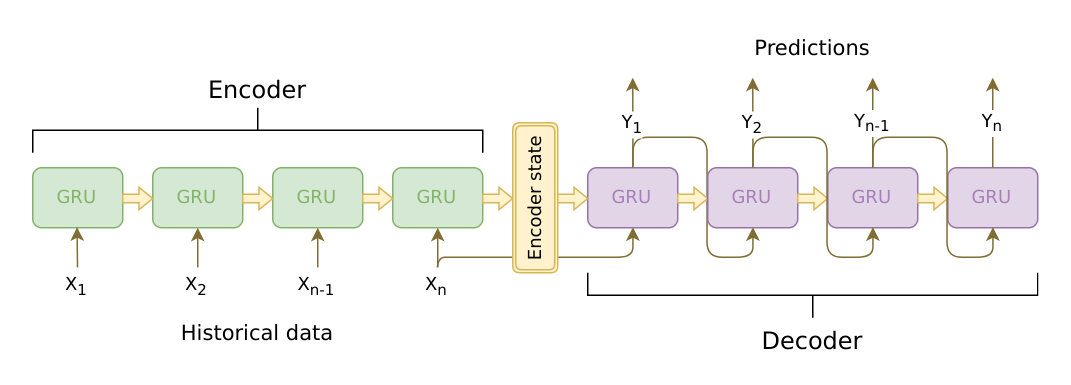

`BIDIRECTIONAL ENCODER`

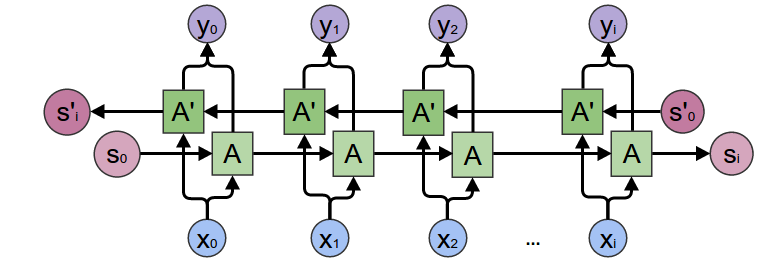

**Computation Graph:**

1.Convert word indexes to embeddings.

2.Pack padded batch of sequences for RNN module.

3.Forward pass through GRU.

4.Unpack padding.

5.Sum bidirectional GRU outputs.

6.Return output and final hidden state

In [14]:
class EncoderRNN(nn.Module):
  def __init__(self,hidden_size,n_layers=1,dropout=0):
    super(EncoderRNN,self).__init__()
    self.n_layers=n_layers
    self.hidden_size=hidden_size
    self.embedding=nn.Embedding(voc.num_words,hidden_size)

   #Initialize GRU; input_size and hidden_size are both set to 'hidden_size' because number of features in word embedding of input  is also equal to 'hidden_size'
    self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                      dropout=(0 if n_layers == 1 else dropout), bidirectional=True)
   #num_layers para in GRU:n_layers=number of recurrent layers.if set to 2,it means stacking 2 GRUs together
   # to form stacked GRU,with second GRU taking input as outputs of previous GRU and computing final result.
   #dropout:introduces dropout layer on outputs of each layer of GRU except last layer if n_layers>1 otherwise dropout=0

  def forward(self,input_seq,input_lengths,hidden=None):
    #converting word indexes to embeddings
    # print('input_seq: %d'%input_seq)
    embedded=self.embedding(input_seq)
    # print('embedded: %d'%embedded)
    # Pack padded batch of sequences for RNN module
    packed=nn.utils.rnn.pack_padded_sequence(embedded,input_lengths)   # link for ref of pack_padded_sequence:https://gist.github.com/HarshTrivedi/f4e7293e941b17d19058f6fb90ab0fec
    
    # Forward pass through GRU
    outputs,hidden=self.gru(packed,hidden)
    # Unpack padding
    outputs, _ =nn.utils.rnn.pad_packed_sequence(outputs)
    # Sum bidirectional GRU outputs
    outputs=outputs[:,:,:self.hidden_size]+outputs[:,:,self.hidden_size:]
    return outputs,hidden


**LUONG GLOBAL ATTENTION MODEL**

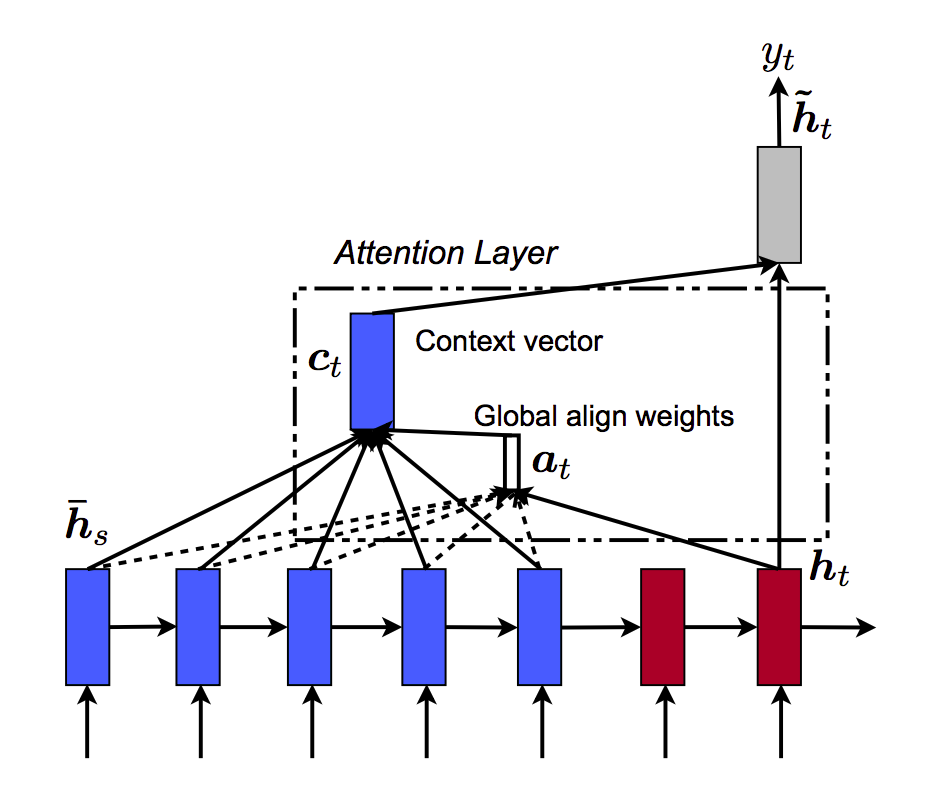

attention energies between the encoder output and decoder output which are called “score functions”:

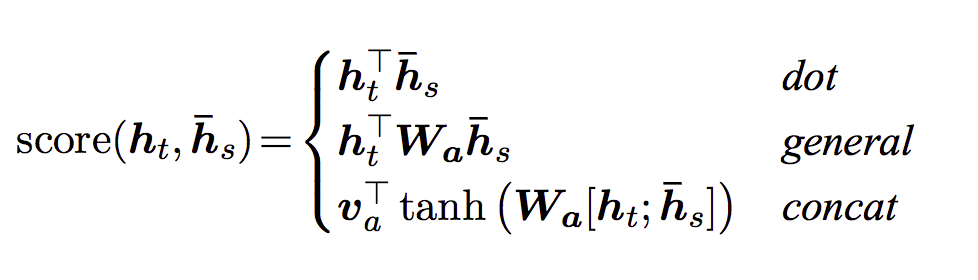

In [15]:
class Attn(nn.Module):
  def __init__(self,method,hidden_size):
    super(Attn,self).__init__()
    self.method=method
    if self.method not in ['dot','general','concat']:
      raise ValueError(self.method,"is not an appropriate attention method.")
    self.hidden_size=hidden_size
    if self.method == 'general':
      self.attn=nn.Linear(self.hidden_size,self.hidden_size)
    elif self.method == 'concat':
      self.attn=nn.Linear(self.hidden_size * 2,hidden_size)
      self.v=nn.Parameter(torch.FloatTensor(hidden_size))

  def dot_score(self,hidden,encoder_output):
    return torch.sum(hidden*encoder_output,dim=2)             #hidden*encoder_output returns matrix size(max_len,hidden_size,1) after torch.sum output is (max_len,hidden_size)

  def general_score(self,hidden,encoder_output):
    energy=self.attn(encoder_output)
    return torch.sum(hidden * energy,dim=2)

  def concat_score(self,hidden,encoder_output):
    energy=self.attn(torch.cat((hidden.expand(encoder_output.size(0),-1,-1),encoder_output),2)).tanh()
    return torch.sum(self.v*energy,dim=2)

  def forward(self,hidden,encoder_outputs):
    # Calculate the attention weights (energies) based on the given method
    if self.method == 'general':
      attn_energies = self.general_score(hidden,encoder_outputs)
    elif self.method == 'concat':
      attn_energies = self.concat_score(hidden,encoder_outputs)
    elif self.method == 'dot':
      attn_energies = self.dot_score(hidden,encoder_outputs)

    # Transpose max_length and batch_size dimensions
    attn_energies = attn_energies.t()                            #attn_energies has size (hidden_size,max_len)

    # Return the softmax normalized probability scores (with added dimension)
    return F.softmax(attn_energies,dim=1).unsqueeze(1)             #(hidden_size,1,max_len)


**Computation Graph**

1.Get embedding of current input word

2.Forward through unidirectional GRU

3.Calculate attention weights from the current GRU output from step 2

4.Multiply attention weights to encoder outputs to get new "weighted sum" context vector

5.Concatenate weighted context vector and GRU output using Luong **h̃**t = tanh(**W**c[**c**t ; **h**t])

6.Predict next word using p(**y**t|**y**<t ,**x**) = softmax(**W**s**h**̃t)  BUT WITHOUT SOFTMAX

7.Return output and final hidden state


Inputs:

    input_step: one time step (one word) of input sequence batch; shape=(1, batch_size)
    last_hidden: final hidden layer of GRU; shape=(n_layers x num_directions, batch_size, hidden_size)
    encoder_outputs: encoder model’s output; shape=(max_length, batch_size, hidden_size)

Outputs:

    output: softmax normalized tensor giving probabilities of each word being the correct next word in the decoded sequence; shape=(batch_size, voc.num_words)
    hidden: final hidden state of GRU; shape=(n_layers x num_directions, batch_size, hidden_size)


In [16]:
class LuongAttnDecoderRNN(nn.Module):
  def __init__(self,attn_model,embedding,hidden_size,output_size,n_layers=1,dropout=0.1):
    super(LuongAttnDecoderRNN,self).__init__()

    #keep for reference 
    self.attn_model=attn_model
    self.hidden_size=hidden_size
    self.output_size=output_size
    self.n_layers=n_layers
    self.dropout=dropout

    #Define layers
    self.embedding=embedding
    self.embedding_dropout=nn.Dropout(dropout)
    self.gru=nn.GRU(hidden_size,hidden_size,n_layers,dropout=(0 if n_layers==1 else dropout))
    self.concat=nn.Linear(hidden_size * 2,hidden_size)
    self.out=nn.Linear(hidden_size,output_size)
    self.attn=Attn(attn_model,hidden_size)

  def forward(self,input_step,last_hidden,encoder_outputs):
    #we run one step(word) at a time
    #Get embedding of current input word
    embedded=self.embedding(input_step)
    embedded=self.embedding_dropout(embedded)
    #Forward through unidirectional GRU
    rnn_output,hidden=self.gru(embedded,last_hidden)
    #Calculate attention weights from current GRU output
    attn_weights=self.attn(rnn_output,encoder_outputs)
    #Multiply attention weights to encoder to get new "weighted sum" context vector
    context=attn_weights.bmm(encoder_outputs.transpose(0,1))
    #Concatenate weighted context vector and GRU output using p(yt|y<t ,x) = softmax(Wsh̃t)
    rnn_output=rnn_output.squeeze(0)
    context=context.squeeze(1)
    concat_input=torch.cat((rnn_output,context),1)
    concat_output=torch.tanh(self.concat(concat_input))
    #Predict next word using p(yt|y<t ,x) = softmax(Wsh̃t)
    output=self.out(concat_output)
    output=F.softmax(output,dim=1)
    return output,hidden

Masked Loss:
coz in some input tensor we pad sequence with zeros now we cant consider that in loss calculation so Masked loss is used .

Below is shown example of working of torch.gather function :
where

index=[[1,2,3],[2,3,1]]

src=[[1,2,3],[4,5,6],[7,8,9]]

result=[[1,5,9],[4,8,3]]

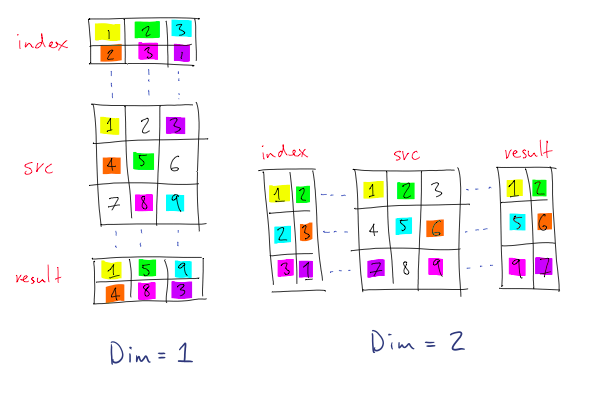

In [17]:
def maskNLLLoss(op,target,mask):
  nTotal=mask.sum()
  crossEntropy=-torch.log(torch.gather(op,1,target.view(-1,1)).squeeze(1))                 #loss=summation(log(probabilities))
  loss=crossEntropy.masked_select(mask).mean()
  loss=loss.to(device)
  return loss,nTotal.item()

**Sequence of Operations:**

1.Forward pass entire input batch through decoder

2.initialize decoder inputs as SOS_token,and hidden state as encoder's final hidden_state
    
3.Forward input batch sequence through decoder one time step at a time

4.If teacher forcing : set next decoder input as the current target;else:set next decoder input as current decoder output

5.calculate and accumulate loss

6.Perform backpropagation

7.Clip gradients

8.Update encoder and decoder model parameters

In [18]:
def train(input_variable,lengths,target_variable,mask,max_target_len,encoder,decoder,embedding,encoder_optimizer,decoder_optimizer,batch_size,clip,max_length=MAX_LENGTH):
  #zero gradients
  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()

  #Set device options
  input_variable=input_variable.to(device)
  lengths=lengths.to(device)
  target_variable=target_variable.to(device)
  mask=mask.to(device)

  #Initialize variables
  loss=0
  print_losses=[]
  n_totals=0

  #Forward pass through encoder
  encoder_outputs,encoder_hidden=encoder(input_variable,lengths)

  #Create initial decoder input (starting with SOS_token for each sent)
  decoder_input=torch.LongTensor([[SOS_token for _ in range(batch_size)]])
  decoder_input = decoder_input.to(device)

  #Set initial decoder hidden state to the encoder's final hidden state
  decoder_hidden=encoder_hidden[:decoder.n_layers]           #':deocder.n_layer' used to access 0th index i.e. if n_layers =1 it will access [0,:,:] and if n_layers=2 it will access [:2,0,0]

  #Determine if we are using teacher forcing this iteration
  use_teacher_forcing=True if random.random() < teacher_forcing_ratio else False

  # Forward batch of sequences through decoder one time step at a time
  if use_teacher_forcing:
      for t in range(max_target_len):
          decoder_output, decoder_hidden = decoder(
              decoder_input, decoder_hidden, encoder_outputs
          )
          # Teacher forcing: next input is current target
          decoder_input = target_variable[t].view(1, -1)
          # Calculate and accumulate loss
          mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
          loss += mask_loss
          print_losses.append(mask_loss.item() * nTotal)
          n_totals += nTotal
  else:
      for t in range(max_target_len):
          decoder_output, decoder_hidden = decoder(
              decoder_input, decoder_hidden, encoder_outputs
          )
          # No teacher forcing: next input is decoder's own current output
          _, topi = decoder_output.topk(1)
          decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
          decoder_input = decoder_input.to(device)
          # Calculate and accumulate loss
          mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
          loss += mask_loss
          print_losses.append(mask_loss.item() * nTotal)
          n_totals += nTotal

  # Perform backpropatation
  loss.backward()

  # Clip gradients: gradients are modified in place
  _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
  _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

  # Adjust model weights
  encoder_optimizer.step()
  decoder_optimizer.step()

  return sum(print_losses) / n_totals

In [19]:
def trainIters(model_name,voc,pairs,encoder,decoder,encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers,save_dir, n_iteration, batch_size, print_every, save_every, clip, loadFilename):
  # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0

    if loadFilename:
      print('started with : {}'.format(checkpoint['iteration']))
      start_iteration = checkpoint['iteration'] + 1        #IF TRAINING IS DISCONNECTED INBETWEEN , WE NEED NOT TO TRAIN FROM SCRATCH AND CAN CONTINUE FROM WHERE IT IS LEFT BEFORE

    #Traiing loop
    print("Training...")
    for iteration in range(start_iteration,n_iteration+1):
      training_batch = training_batches[iteration-1]
    
      #Extract fields from batch
      input_variable,lengths,target_variable,mask,max_target_len=training_batch

      #Run a training iteration with batch
      loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                      decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
      
      print_loss += loss

      # Print progress
      if iteration % print_every == 0:
          print_loss_avg = print_loss / print_every
          print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
          print_loss = 0

      if (iteration % save_every == 0):
        directory = os.path.join(save_dir,model_name,'{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
        if not os.path.exists(directory):
                  os.makedirs(directory)
        torch.save({
            'iteration': iteration,
            'en': encoder.state_dict(),
            'de': decoder.state_dict(),
            'en_opt': encoder_optimizer.state_dict(),
            'de_opt': decoder_optimizer.state_dict(),
            'loss': loss,
            'voc_dict': voc.__dict__,
            'embedding': embedding.state_dict()
        }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))



In [21]:
# Configure models
model_name = 'chatbot_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64
n_iteration_val=False

# Set checkpoint to load from; set to None if starting from scratch
load_trained=True               #set to true if want to load pretrained model
# load_trained=False              #sett to false if training from scratch
if load_trained:
  checkpoint_iter = 10000
  loadFilename = os.path.join('/content/drive/My Drive/Projects/NLP/data/chatbot', model_name,
                           '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
                           '{}_checkpoint.tar'.format(checkpoint_iter))

else:
  loadFilename=None

# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']
    n_iteration_val=True


print('Building encoder and decoder ...')
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')


Building encoder and decoder ...
Models built and ready to go!


In [22]:
print(loadFilename)

/content/drive/My Drive/Projects/NLP/data/chatbot/chatbot_model/2-2_500/15000_checkpoint.tar


In [75]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
if n_iteration_val:
  n_iteration = 15000
else:
  n_iteration=4000
print_every = 1
save_every = 500

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# If you have cuda, configure cuda to call
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers,'/content/drive/My Drive/Projects/NLP/data/chatbot', n_iteration, batch_size,
           print_every, save_every, clip, loadFilename)

Streaming output truncated to the last 5000 lines.
Iteration: 10002; Percent complete: 66.7%; Average loss: 1.1822
Iteration: 10003; Percent complete: 66.7%; Average loss: 1.3712
Iteration: 10004; Percent complete: 66.7%; Average loss: 1.2083
Iteration: 10005; Percent complete: 66.7%; Average loss: 1.1214
Iteration: 10006; Percent complete: 66.7%; Average loss: 1.1349
Iteration: 10007; Percent complete: 66.7%; Average loss: 1.2622
Iteration: 10008; Percent complete: 66.7%; Average loss: 1.3788
Iteration: 10009; Percent complete: 66.7%; Average loss: 1.2158
Iteration: 10010; Percent complete: 66.7%; Average loss: 1.4648
Iteration: 10011; Percent complete: 66.7%; Average loss: 1.4859
Iteration: 10012; Percent complete: 66.7%; Average loss: 1.2040
Iteration: 10013; Percent complete: 66.8%; Average loss: 1.3086
Iteration: 10014; Percent complete: 66.8%; Average loss: 1.3523
Iteration: 10015; Percent complete: 66.8%; Average loss: 1.1904
Iteration: 10016; Percent complete: 66.8%; Average lo

**Greedy decoding**

Greedy decoding is the decoding method that we use during training when we are NOT using teacher forcing.n other words, for each time step, we simply choose the word from decoder_output with the highest softmax value. This decoding method is optimal on a single time-step level.

In [23]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

In [27]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    try:
      while(1):
          try:
              # Get input sentence
              input_sentence = input('> ')
              # Check if it is quit case
              if input_sentence == 'q' or input_sentence == 'quit': break
              # Normalize sentence
              input_sentence = normalizeString(input_sentence)
              # Evaluate sentence
              output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
              # Format and print response sentence
              output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
              print('Bot:', ' '.join(output_words))

          except KeyError:
              print("Error: Encountered unknown word.")
    except:
      print('|| THANK YOU ||')

In [29]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc)

> hey
Bot: hey . how are you ?
> fine
Bot: fine i ll be fine . !
> what are you doing ?
Bot: i was just looking for you . this .
> what is your name ?
Bot: victor frankenstein sir . of geneva . !
> will you help me ?
Bot: i don t have time . maybe .
> i will not take your much time
Bot: i want you to take any more .
> are you busy ?
Bot: i ve been all right .
> oh okay then
Bot: okay . how are you ? okay
> yes
Bot: what s the matter with you ?
> I want to book tickets
Bot: to run into my office . our times
> okay then i ll meet you later for same
Bot: okay . when i ll be fine .
> fine
Bot: fine i ll be fine . !
> Okay BYE
Bot: okay . tom . tom . !
> bye bye
Bot: bye bye . tom and nuts !
|| THANK YOU ||
